In [6]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [7]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        #make all of the attributes for the class:
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol

    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        #set the random seed so that initializing the matrices can be replicated
        np.random.seed(self.random_state)
        
        #create random matrices W, H:
        W = np.random.random((m, self.rank))
        H = np.random.random((self.rank, n))
        
        #save them as attributes:
        self.W = W
        self.H = H
    
        return W, H
      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        self.initialize_matrices(V.shape[0], V.shape[1])   #put here so that just have to call fit and
                                                           #don't need to call both functions when call fit
        
        for k in range(self.maxiter):
            #make w be a CVXPY variable bc want the optimal W,H and CVXPY can be 
            #used to make an optimization problem
            w = cp.Variable((V.shape[0], self.rank), nonneg=True)  #make w variable with shape of W
            obj = cp.Minimize(cp.norm(V - w @ self.H, p = 'fro'))  #have self.H bc want opt W given H
            prob = cp.Problem(obj)   #have no constraints
            prob.solve()
            self.W = w.value         #w.value is result from opt prob, so opt w
            
            #make h be a CVXPY variable so can make optimization prob to solve for opt H
            h = cp.Variable((self.rank, V.shape[1]), nonneg=True)
            obj = cp.Minimize(cp.norm(V - self.W @ h, p = 'fro'))  #have self.W bc want opt H given w
            prob = cp.Problem(obj)   #have no constraints
            prob.solve()
            self.H = h.value         #h.value is result from opt prob, so opt h
            
            if np.linalg.norm(V - self.W @ self.H, ord = 'fro') < self.tol:  #check tolerance
                break
        
    def reconstruct(self):
        return self.W @ self.H    #reconstruct, return V by multiplying W, H


In [8]:
#test probs 1,2:
N = NMFRecommender()
N.initialize_matrices(3,3)
N.fit(np.array([[4,2,5],[4,2,3],[8,3,6]]))
N.reconstruct()   #should return the V array put into fit

array([[4., 2., 5.],
       [4., 2., 3.],
       [8., 3., 6.]])

In [9]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    #V is constructed to match the grocery store example
    nmf = NMFRecommender(rank = 2)  #construct class object so that can use the class on V matrix
                                    #have rank = 2 since we only care about 2 of the components
    
    #do NMF on V once to get W, H matrices:
    nmf.fit(V)
    
    #get number of people who have higher weights in component 2 than in component 1: so want check
    #components in H since H has the people in it
    H = nmf.H    
    counter = 0
    for i in range(len(H[0])):   #loop through 1st row in H
        if H[0][i] < H[1][i]:    #check if the component in 1st row is less than component in 2nd row
            counter +=1          
    
    #return W, H
    return nmf.W, nmf.H, counter

In [10]:
#test prob 3:
print(prob3())

(array([[4.32480191e-01, 1.55954416e+00],
       [7.28906415e-01, 2.67373283e+00],
       [2.59466489e-01, 1.23238130e+00],
       [2.77259088e+00, 7.64369539e-08],
       [2.08546906e-09, 3.68889128e-01]]), array([[4.28503903e-08, 7.25973906e-01, 1.07543057e+00, 1.44598707e+00,
        3.52852850e-01, 3.65398494e-01],
       [5.85611950e-01, 7.72213331e-01, 6.59496409e-02, 5.89472429e-09,
        8.03616848e-01, 7.67499335e-01]]), 4)


In [47]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [45]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    faces = get_faces()          #load in facial dataset
    alpha = [0, .2, .5]
    l1_ratio = [0, 10**-5, 10]
    
    #perform the grid search
    for a in alpha:
        for r in l1_ratio:
            nmf = NMF(n_components = 75, alpha = a, l1_ratio = r)
            W = nmf.fit_transform(faces)   #will fit and transform
            H = nmf.components_

            #want reconstruct the 3rd face so will acess it at index 2 (since indexing starts at 0): 
            #reconstruct by multiplying the W and H get together (like the reconstruct function above)
            show((W@H)[:, 2], plt_show = True)
            print("alpha: ", a, "l1 ratio ", r)
    

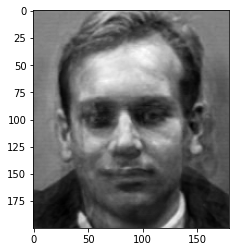

alpha:  0 l1 ratio  0


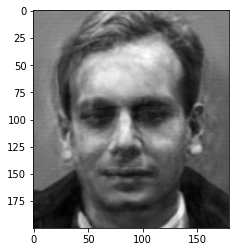

alpha:  0 l1 ratio  1e-05


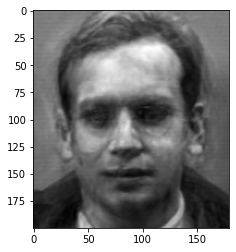

alpha:  0 l1 ratio  10


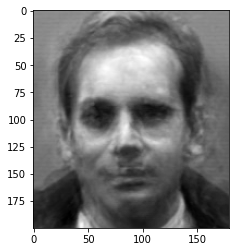

alpha:  0.2 l1 ratio  0


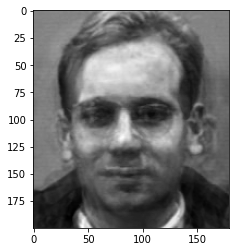

alpha:  0.2 l1 ratio  1e-05


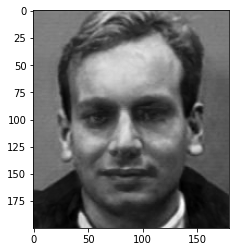

alpha:  0.2 l1 ratio  10


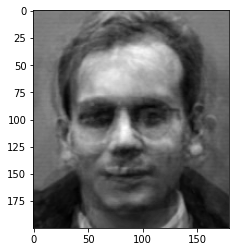

alpha:  0.5 l1 ratio  0


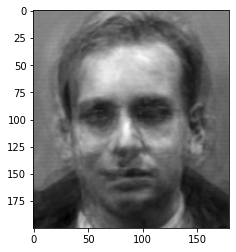

alpha:  0.5 l1 ratio  1e-05


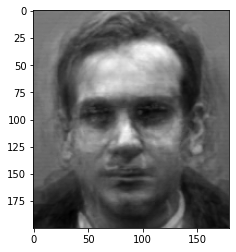

alpha:  0.5 l1 ratio  10


In [46]:
prob4()

The alpha value and ratio value that give the best image are alpha: 0.2 and l1_ratio: 10 because it looks like the very best one out of all 9 faces                                                                                        
BOOYAH!!!!!!! WOOHOO!!!!! YAY!!!!

In [54]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    faces = get_faces()
    #plot the 1st 10 faces:
    show(faces[:,1], plt_show = True)
    show(faces[:,11], plt_show = True)
    
    nmf = NMF(n_components = 75, alpha = 0.2, l1_ratio = 10)  #run NMF on faces again using best parameters
                                                              #from prob 4
    W = nmf.fit_transform(faces)   #will fit and transform
    H = nmf.components_
    
    #want to look at all faces and see which components of all the faces are the same
    #get the first basis faces for the 2nd and 12th faces
    max2 = np.argsort(H[:,1])[-10:]
    max12 = np.argsort(H[:,11])[-10:]
    
    print("Faces close to 2")
    for i in max2:
        show(W[:,i], plt_show = True)
        
    print("Faces close to 12")
    for j in max12:
        show(W[:,j], plt_show = True)


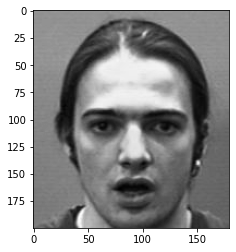

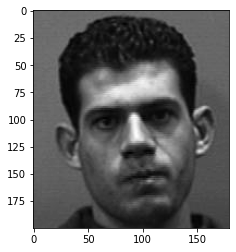

Faces close to 2


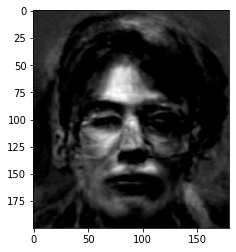

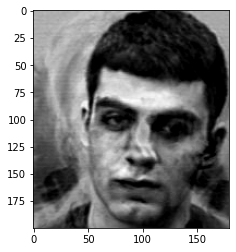

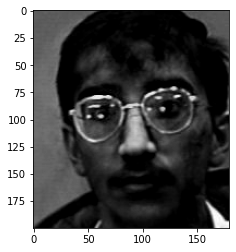

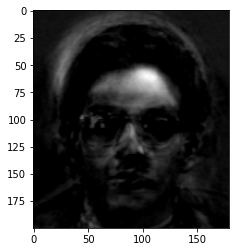

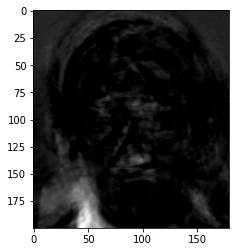

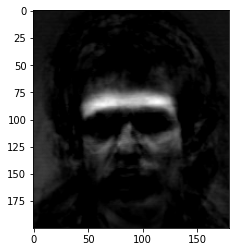

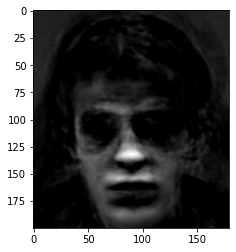

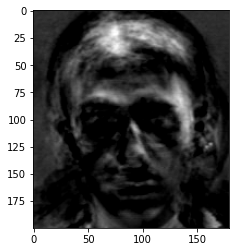

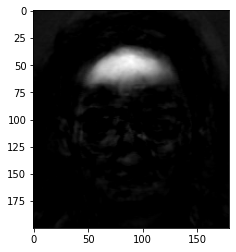

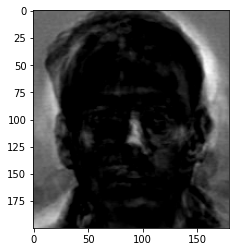

Faces close to 12


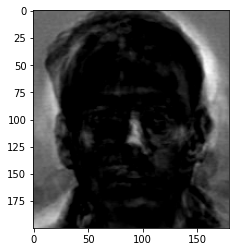

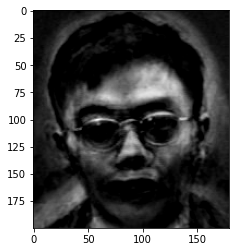

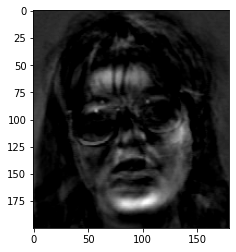

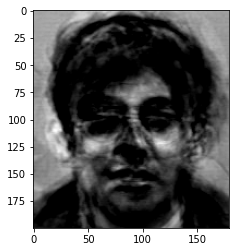

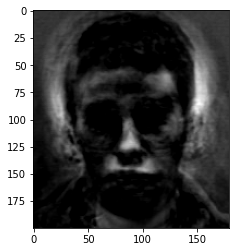

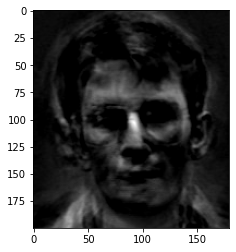

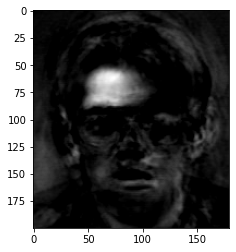

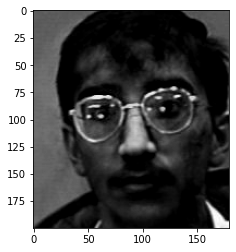

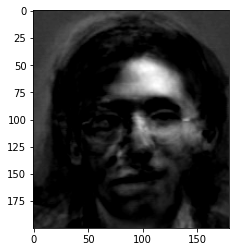

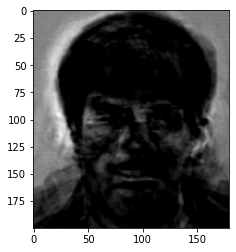

In [55]:
prob5()